In [1]:
import math
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# import cv2
plt.rcParams['image.cmap'] = 'gray'

### import functions from scripts

In [2]:
import os
os.chdir('../saliency_model/')

In [3]:
from utils import *
from itti_koch_features import *

## Load the images

In [4]:
img = mpimg.imread('../imgs/balloons.png')
# img2 = cv2.imread('../imgs/balloons.png')

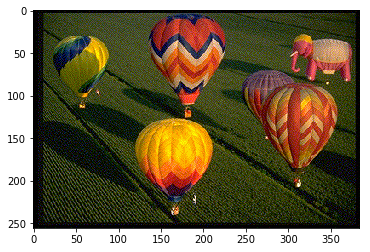

In [5]:
plt.imshow(img);

convert to double if image is uint8

In [6]:
# TODO 

---

## Determine the size and the number of center scales:  
First we scale the image to different sizes, so it has different resolutions we can work with.

In [7]:
mapwidth = 64
mapheight = round(img.shape[0] * (mapwidth / img.shape[1]))
scalars = [1, 2, 3]

img_scales = downsample_image(img, mapheight, mapwidth, scalars)

In [8]:
mapsize = [ round(np.size(img,0) / np.size(img,1) * mapwidth), mapwidth ];
mapsize
# chanmap = chanmap + wj * imresize(maps{ci}{cj}, mapSize ); #TODO: weighted scale

[43, 64]

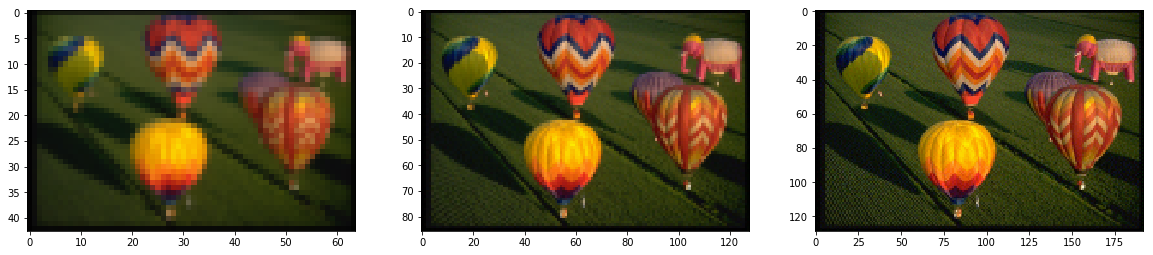

In [9]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img_scales[0])
ax[1].imshow(img_scales[1])
ax[2].imshow(img_scales[2]);

---

## CHANNELS

### Channel 1: Compute intensity

Compute intensity of the image as average over the RGB values for each input scale. 

In [10]:
intensities = compute_intensity(img_scales)

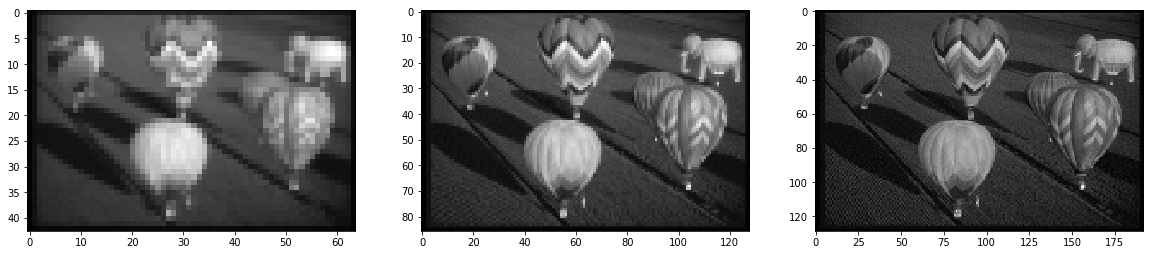

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(intensities[0])
ax[1].imshow(intensities[1])
ax[2].imshow(intensities[2]);

## SALIENCY
### (1) apply center-surround to feature map

Convolve the feature maps with the center surround function / Mexican Hat to get the saliency maps.

In [12]:
def convolve_receptive_field(input_list, sigma1, sigma2, matlab_code):
    """
    convolves all images of the input list with the sigma-combinations;
    returns a nested list of convolved images, where the first index is associated with the image,
    and the second index is associated with the sigmas (kernel-size)
    """
    if (len(sigma1) != len(sigma2)):
        # TODO make this a useful error message...
        print("Amount of sigmas for inner and outer Gaussian have to be the same!")
        return
        
    # outer loop over the images
    output_list = []
    for img in input_list:
        
        # inner loop over the sigma-combinations
        img_hat = []
        for s1, s2 in zip(sigma1, sigma2):
            # create receptive field and convolve with image
            rf = receptive_field_matrix(lambda x, y: mexican_hat(x, y, s1, s2))
            # list containing different kernel sizes
            convolved = signal.convolve(img, rf, mode='same')
            
            # direct copy of matlab code... why do we need this??
            if (matlab_code == True):
                convolved = (img - convolved)**2
            
            img_hat.append(convolved)
            
        # list containing convolved versions of all images
        output_list.append(img_hat)
        
    return output_list

In [13]:
sigma1 = [1, 1]
sigma2 = [10, 12]
convolution_maps = convolve_receptive_field(intensities, sigma1, sigma2, matlab_code=True)

In [14]:
def gaussian2D_k(x, y, sigma, k):
    '''create 2D Gaussian distribution'''
    return (1.0/(2*math.pi*(k**2 * sigma**2)))*math.exp(-(1.0/(2*(k**2 * sigma**2)))*(x**2 + y**2))


In [15]:
img = intensities[2]

rf1 = receptive_field_matrix(lambda x, y: gaussian2D_k(x, y, .1, 1))
rf = receptive_field_matrix(lambda x, y: gaussian2D_k(x, y, 3, 1))

img = signal.convolve2d(img, rf1, mode='same')
convolved = signal.convolve2d(img, rf, mode='same')
# convolved = signal.convolve(rf, img, mode='valid')

res = (img - convolved)**2
res2 = abs(img-convolved)

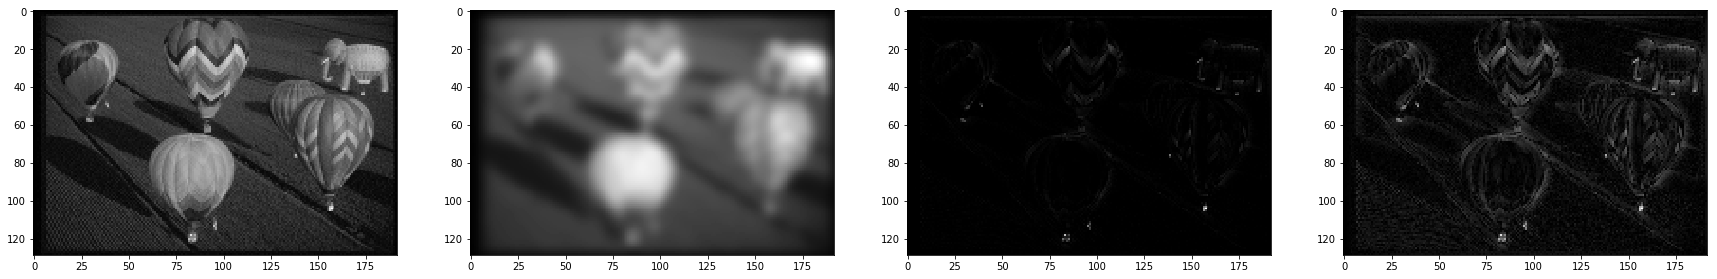

In [16]:
fig, ax = plt.subplots(1, 4, figsize=(30,30))
ax[0].imshow(img);
ax[1].imshow(convolved);
ax[2].imshow(res);
ax[3].imshow(res2);

In [17]:
rd = rf1 - rf
# rd = (rd - rd.min()) / (rd.max() - rd.min())


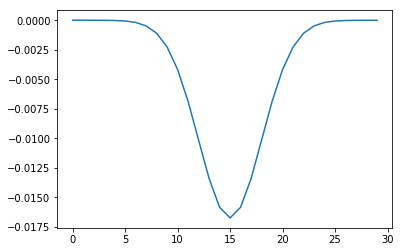

In [18]:
plt.plot(rd[14,:])

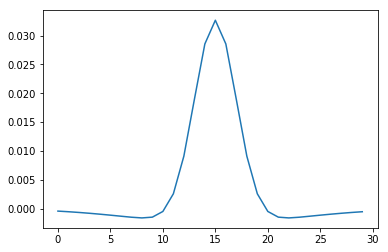

In [19]:
rf = receptive_field_matrix(lambda x, y: mexican_hat(x, y, 2,8))
plt.plot(rf[14,:])

**Following figure:**  
3 different image scales convolved with two different kernels (2x3)

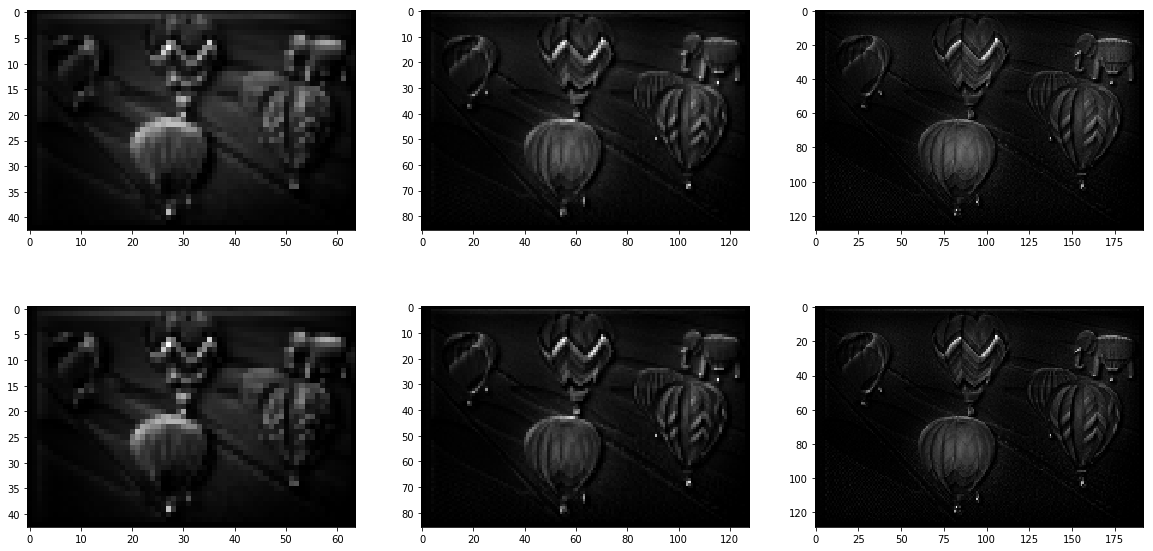

In [20]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0].imshow(convolution_maps[0][0])
ax[1,0].imshow(convolution_maps[0][1])
#ax[2,0].imshow(convolved[0][2])
ax[0,1].imshow(convolution_maps[1][0])
ax[1,1].imshow(convolution_maps[1][1])
#ax[2,1].imshow(convolved[1][2])
ax[0,2].imshow(convolution_maps[2][0])
ax[1,2].imshow(convolution_maps[2][1]);
#ax[2,2].imshow(convolved[2][2])

## *QUESTION*:
What is done in the original MATLAB code is the following:   
(1) create 1-dim Gausskernel and convolve it with the image twice (in two dimensions) - I think this should be the same as what we directly do in two dimensions? They also only use a Gaussian kernel and not a real receptive field...  
(2) after convolution, get the saliency map by subtracting the convoluted image from the original intensities and squaring the difference (see what happens when flagging matlab_code to True)

**Why would we have to do this?**

## (2) judge the peakiness of a saliency map

In [21]:
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from skimage.feature import peak_local_max
from skimage import data, img_as_float

In [22]:
def normalize(X):
    return (X - X.min()) / (X.max() - X.min())


In [23]:
convolution_maps_scaled2 = normalize(convolution_maps[2][1])
convolution_maps_scaled2.min()

0.0

In [24]:
convolution_maps[2][1].min()

1.0305075736904681e-10

## Normalize convolution_maps

In [25]:
np.shape(convolution_maps)

(3, 2)

In [26]:
for i in range(3):
    for j in range(2):
        convolution_maps[i][j] = normalize(convolution_maps[i][j])

In [27]:
convolution_maps[2][0].max()

1.0

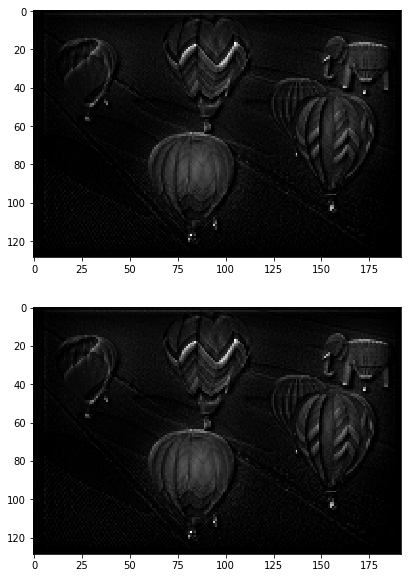

In [28]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
ax[0].imshow(convolution_maps[2][1])
ax[1].imshow(convolution_maps_scaled2);

In [29]:
def get_local_maxima(sal_map, min_distance=1, threshold_abs=0.1):
    '''
    Input image, find local minima with min_distance window between points. 
    Return average of local minimas and their number
    '''
    
    coordinates = peak_local_max(sal_map, min_distance=min_distance, threshold_abs=threshold_abs)
    
    peak_avg = 0
    peak_num = np.shape(coordinates)[0]
        
    for x,y in coordinates:
        peak_avg = peak_avg + sal_map[x][y]
    
    peak_avg = peak_avg/peak_num
    
    return peak_avg, peak_num

In [30]:
def get_weight_map(peak_avg, peak_num):
    '''
    based on number of peaks and their average return weight of the map used for normalization
    measure of pickiness
    '''
    
    if peak_num <= 1:
        return 1
    else:
        return (1 - peak_avg)**2
            

In [31]:
peak_avg, peak_num = get_local_maxima(convolution_maps[2][1], min_distance=1)
weight21 = get_weight_map(peak_avg, peak_num)
weight21

0.6102773227621994

In [32]:
peak_avg, peak_num = get_local_maxima(convolution_maps[2][0])
weight20 = get_weight_map(peak_avg, peak_num)
weight20

0.6001698908125148

In [33]:
peak_avg, peak_num = get_local_maxima(convolution_maps[1][1])
weight11 = get_weight_map(peak_avg, peak_num)
weight11

0.5562996368129962

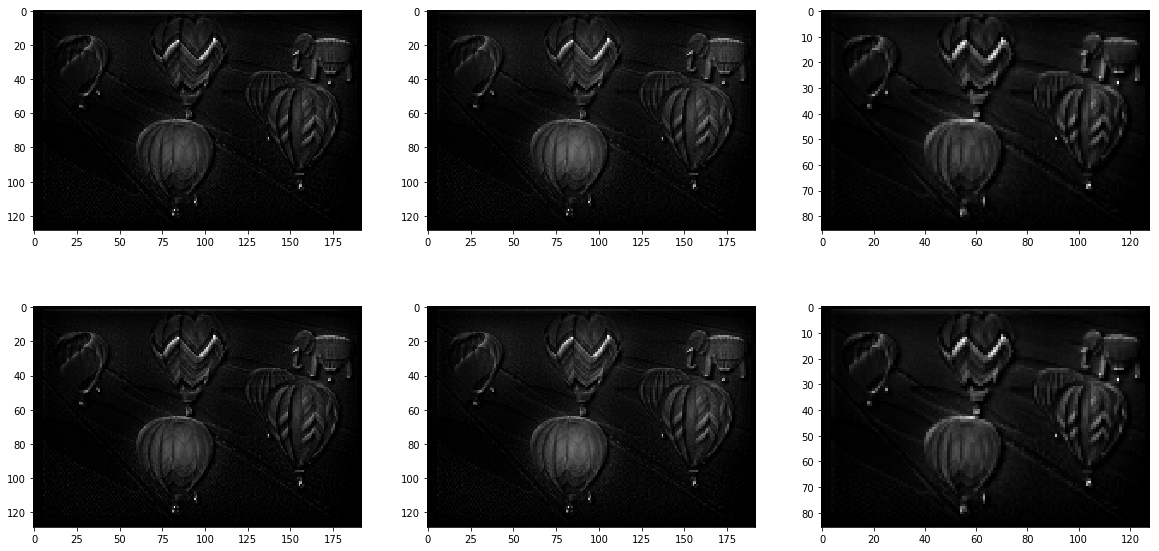

In [34]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax[0,0].imshow(convolution_maps[2][1])
ax[1,0].imshow(convolution_maps[2][1] * weight21)

ax[0,1].imshow(convolution_maps[2][0])
ax[1,1].imshow(convolution_maps[2][0] * weight20)

ax[0,2].imshow(convolution_maps[1][1])
ax[1,2].imshow(convolution_maps[1][1] * weight11);


In [35]:
n=10
# image_max is the dilation of im with a 20*20 structuring element
# It is used within peak_local_max function
image_max = ndi.maximum_filter(convolution_maps[2][1], size=n, mode='reflect')  # just for visualization

# Comparison between image_max and im to find the coordinates of local maxima
coordinates = peak_local_max(convolution_maps[2][1], min_distance=n)

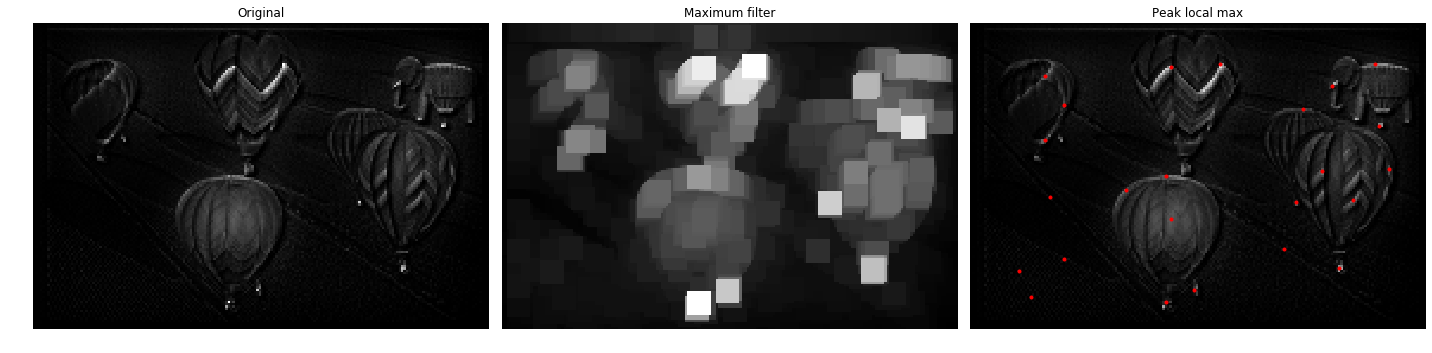

In [36]:
# display results
fig, axes = plt.subplots(1, 3, figsize=(20, 20), sharex=True, sharey=True)
ax = axes.ravel()
ax[0].imshow(convolution_maps[2][1], cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('Original')

ax[1].imshow(image_max, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('Maximum filter')

ax[2].imshow(convolution_maps[2][1], cmap=plt.cm.gray)
ax[2].autoscale(False)
ax[2].plot(coordinates[:, 1], coordinates[:, 0], 'r.')
ax[2].axis('off')
ax[2].set_title('Peak local max')

fig.tight_layout()

In [37]:
# TODO look at MATLAB code
curr_img = convolution_maps[0][0]

# ref_img 

## next steps:
(1) create a weighted sum of the created saliency maps (weight according to their "peakiness", as done in MATLAB?) and normalize  
(2) if the channel has different features (like RGB in colors), create also a weighted sum of those saliency maps  
(3) combine the saliency maps for the different channels (i.e. intensity, color, orientation and color bias) to one saliency map by a weighted sum  
(3a) top-down modulation here?

-----

## Other features: 
Not in the features file yet.

### Compute color channels

In [38]:
r = img[:,:,0]
g = img[:,:,1]
b = img[:,:,2]

IndexError: too many indices for array

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(r)
ax[1].imshow(g)
ax[2].imshow(b);

In [ ]:
# by = ((b - np.min(r,g)) / np.max(np.max(r,g),b)) # (B-Y)
# rg = ((r - g) /np.max(np.max(r,g),b)); # (R-G)

In [ ]:
by = np.divide((b - np.minimum(r,g)), np.maximum(np.maximum(r,g),b)) # (B-Y)
by_no_nan = np.nan_to_num(by)

In [ ]:
rg = ((r - g) /np.maximum(np.maximum(r,g),b)); # (R-G)
rg_no_nan = np.nan_to_num(rg)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(rg)
ax[1].imshow(by);

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(rg_no_nan)
ax[1].imshow(by_no_nan);

### Orientation filter

In [ ]:
from skimage.util import img_as_float
from skimage.filters import gabor_kernel

In [ ]:
theta = 1
theta = theta / 4. * np.pi
sigma = 4
frequency = 0.25

kernel = np.real(gabor_kernel(frequency, theta=theta,
                              sigma_x=sigma, sigma_y=sigma))

In [ ]:
plt.imshow(kernel);

In [ ]:
np.shape(kernel)

In [ ]:
from scipy import ndimage as nd

In [ ]:
def compute_feats(image, kernels):
    feats = np.zeros((len(kernels), 2), dtype=np.double)
    for k, kernel in enumerate(kernels):
        filtered = nd.convolve(image, kernel, mode='wrap')
        feats[k, 0] = filtered.mean()
        feats[k, 1] = filtered.var()
    return feats

In [ ]:
from skimage import data
brick = img_as_float(data.load('brick.png'))
np.shape(brick)

In [ ]:
orientation = nd.convolve(img_list[1][:,:,0], kernel)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(img_list[1])
ax[1].imshow(orientation);

### Color Bias

In [ ]:
from skimage.color import rgb2hsv

In [ ]:
img_hsv = rgb2hsv(img)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,15))
ax[0].imshow(img)
ax[1].imshow(img_hsv);

----